In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import functools
from tqdm import notebook
from matplotlib import gridspec
from matplotlib import rc


#import models
from models import ScoreNet_2D
from models import MLP, get_timestep_embedding

#import training fns
from training import loss_fn, train_model, CDE_loss_fn_2D

#import SDE functions
from SDE import marginal_prob_std_fn_2D as marginal_prob_std_fn
from SDE import diffusion_coeff_fn_2D as diffusion_coeff_fn

#import sampling functions
from sampling import Euler_Maruyama_sampler_2D as Euler_Maruyama_sampler
from sampling import pc_sampler_2D as pc_sampler
from sampling import ode_sampler_2D as ode_sampler
from sampling import CDE_Euler_Maruyama_sampler_2D as CDE_Euler_Maruyama_sampler
from sampling import CDE_pc_sampler_2D as CDE_pc_sampler
from sampling import CDiffE_Euler_Maruyama_sampler_2D as CDiffE_Euler_Maruyama_sampler
from sampling import CDiffE_pc_sampler_2D as CDiffE_pc_sampler
from sampling import SMCDiff_Euler_Maruyama_sampler_2D as SMCDiff_Euler_Maruyama_sampler
from sampling import SMCDiff_pc_sampler_2D as SMCDiff_pc_sampler

# Simple diffusion plot

#### Train model on moons dataset. Get visualisations of forward process by sampling from marginal_prob_std_fn for different t. Get visualisations of the reverse process by sampling from pc_sampler at different t.

In [2]:
moons = datasets.make_moons(n_samples=50000, noise=0.01)[0]

In [86]:
score_model = ScoreNet_2D(marginal_prob_std=marginal_prob_std_fn)

In [87]:
losses = train_model(score_model, moons, loss_fn, marginal_prob_std_fn, 'moons_test.pth', epochs = 200, batch_size = 500)

  0%|          | 0/200 [00:00<?, ?it/s]

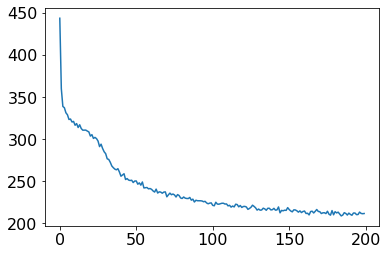

In [88]:
plt.plot(losses)

In [89]:
pc_samples = pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

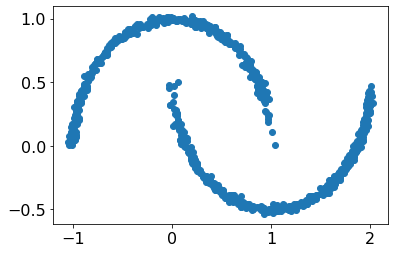

In [90]:
plt.scatter(pc_samples[:,0], pc_samples[:,1])

In [4]:
#Implimentation from shi et al - best model so far :)
class ScoreNet_2D(nn.Module):
    
    def __init__(self, marginal_prob_dist):
        super().__init__()
        self.marginal_prob_dist = marginal_prob_dist
        
        self.net = MLP(3 * 32,
                       layer_widths=[128,128] + [2],
                       activate_final = False,
                       activation_fn=torch.nn.LeakyReLU())

        self.t_encoder = MLP(16,
                             layer_widths=[16] + [32],
                             activate_final = True,
                             activation_fn=torch.nn.LeakyReLU())

        self.xy_encoder = MLP(2,
                              layer_widths=[32] + [64],
                              activate_final = True,
                              activation_fn=torch.nn.LeakyReLU())
        
    def forward(self, x):
        t = x[:, -1]
        _, norm = self.marginal_prob_dist(t)
        t = t.reshape(-1,1)
        xy = x[:,[0,1]]
        
        t_emb = get_timestep_embedding(t, 16, 10000)
        t_emb = self.t_encoder(t_emb)
        xy_emb = self.xy_encoder(xy)

        
        h = torch.cat([xy_emb, t_emb], -1)

        out = self.net(h) 

        out = out / norm[:,None]
        return out
    

In [5]:
def loss_fn(model, x, marginal_prob_dist_fn, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the mean and standard deviation of the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0]) * (1. - eps) + eps  
    mean_coeff, std = marginal_prob_dist_fn(random_t)
    random_t = torch.reshape(random_t, (x.shape[0], 1))
    z = torch.randn_like(x)
    perturbed_x = x * mean_coeff[:, None] + z * std[:, None]
    x_with_t = torch.hstack([perturbed_x,random_t])
    x_with_t = x_with_t.to(torch.float32)
    score = model(x_with_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=0))
    return loss

In [6]:
def marginal_prob_dist(t, beta_min, beta_max):
    t_squared = torch.pow(t, 2)
    mean_coeff = torch.exp(-1/4 * t_squared * (beta_max - beta_min) - 1/2 * t * beta_min)
    sd = torch.sqrt(1 - torch.exp(-1/2 * t_squared * (beta_max - beta_min) - t * beta_min))
    return mean_coeff, sd

def beta_t(t, beta_min, beta_max):
    return beta_min + t*(beta_max - beta_min)

beta_min = 0.1
beta_max = 20

marginal_prob_dist_fn = functools.partial(marginal_prob_dist, beta_min=beta_min, beta_max=beta_max)
beta_t_fn = functools.partial(beta_t, beta_min=beta_min, beta_max=beta_max)

In [7]:
score_model = ScoreNet_2D(marginal_prob_dist=marginal_prob_dist_fn)

In [9]:
losses = train_model(score_model, moons, loss_fn, marginal_prob_dist_fn, 'models/moons.pth', epochs = 100, batch_size = 64)





  0%|          | 0/100 [00:00<?, ?it/s]

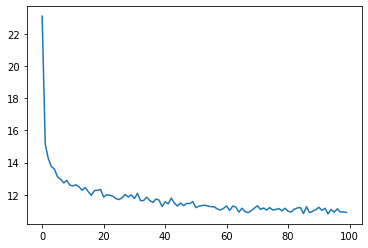

In [10]:
plt.plot(losses)

In [57]:
num_steps =  1000
signal_to_noise_ratio = 0.2
def pc_sampler(score_model, marginal_prob_dist, beta_t, 
               batch_size=1000, num_steps=num_steps, eps=1e-3, snr = signal_to_noise_ratio):
    
    t = torch.ones(batch_size)
    init_x = torch.randn(batch_size, 2)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    xs = [x]
    
    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size) * time_step
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))

            x_with_t = torch.hstack([x, batch_time_step_])
            
            # Corrector step (Langevin MCMC)
            b = beta_t(t=batch_time_step)[:,None]/num_steps
            alpha = 1 - b
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * alpha * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)  
            x_with_t = torch.hstack([x, batch_time_step_])
            
            # Predictor step
            b = beta_t(t=batch_time_step)[:,None]
            score = score_model(x_with_t)
            mean_x = x + (1/2 * b + b * score) * step_size
            x = mean_x + torch.sqrt(step_size) * torch.sqrt(b) * torch.randn_like(x)  
            xs.append(x)
    # Do not include any noise in the last sampling step.
    return mean_x, xs

In [58]:
#for sampling, will take samples at t=T, t=3T/4, t=T/2, t=T/4, t=eps
#can plot the scatter plot, and the density plot of the x variable to show convergence to normal dist
score_model = ScoreNet_2D(marginal_prob_dist=marginal_prob_dist_fn)
ckpt = torch.load('models/moons.pth')
score_model.load_state_dict(ckpt)
pc_samples, xs = pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

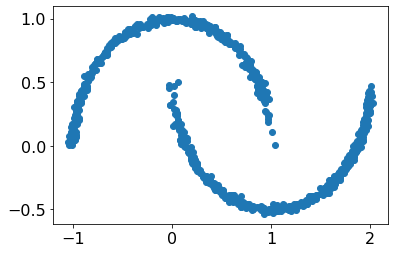

In [91]:
plt.scatter(pc_samples[:,0], pc_samples[:,1])

In [60]:
def get_diffused(data, t, marginal_prob_dist):
    data = torch.tensor(data)
    mean_coeff, sd = marginal_prob_dist(t)
    diffused = mean_coeff*data + torch.randn(data.shape[0], 2) * sd
    return diffused

In [93]:
idx = np.random.randint(50000, size=1000)
sample = moons[idx]

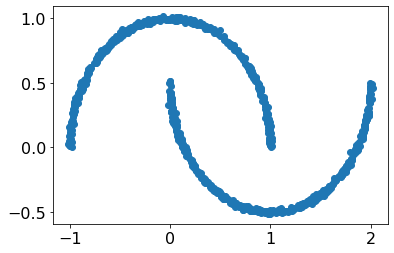

In [94]:
plt.scatter(sample[:,0], sample[:,1])

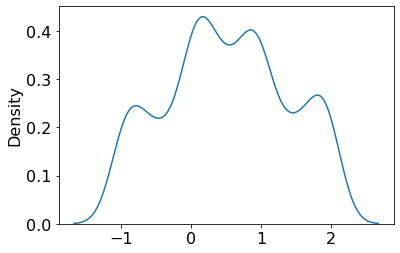

In [95]:
sns.kdeplot(sample[:,0])

In [96]:
np.mean(sample[:,0])

0.5180402076557494

In [97]:
np.var(sample[:,0])

0.7503256487211466

In [66]:
small_diff = get_diffused(sample, torch.tensor(0.1), marginal_prob_dist_fn)

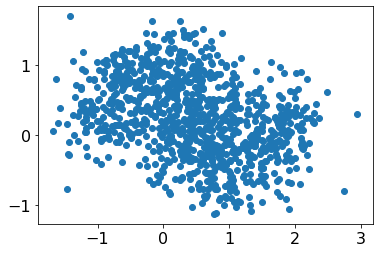

In [67]:
plt.scatter(small_diff[:,0], small_diff[:,1])

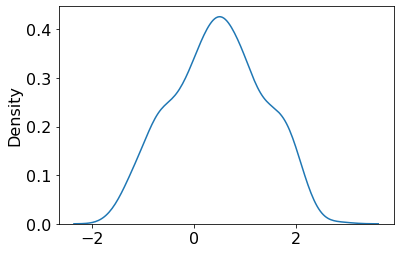

In [68]:
sns.kdeplot(small_diff[:,0])

In [69]:
torch.mean(small_diff[:,0])

tensor(0.4712, dtype=torch.float64)

In [70]:
torch.var(small_diff[:,0])

tensor(0.8023, dtype=torch.float64)

In [71]:
half_diff = get_diffused(sample, torch.tensor(0.5), marginal_prob_dist_fn)

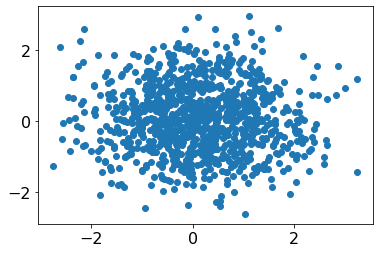

In [72]:
plt.scatter(half_diff[:,0], half_diff[:,1])

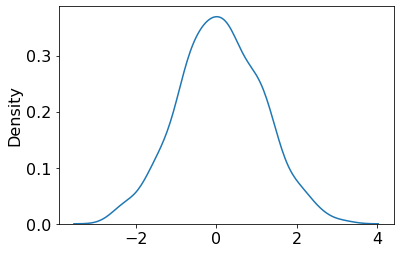

In [73]:
sns.kdeplot(half_diff[:,0])

In [74]:
torch.mean(half_diff[:,0])

tensor(0.1028, dtype=torch.float64)

In [75]:
torch.var(half_diff[:,0])

tensor(1.0868, dtype=torch.float64)

In [76]:
full_diff = get_diffused(sample, torch.tensor(1), marginal_prob_dist_fn)

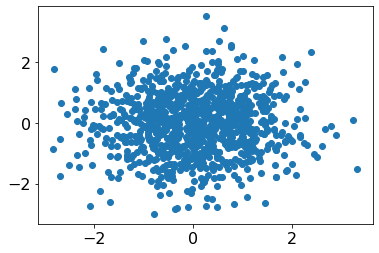

In [77]:
plt.scatter(full_diff[:,0], full_diff[:,1])

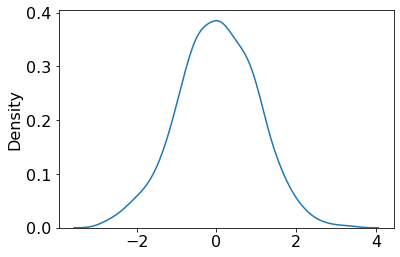

In [78]:
sns.kdeplot(full_diff[:,0])

In [79]:
torch.mean(full_diff[:,0])

tensor(0.0301, dtype=torch.float64)

In [80]:
torch.var(full_diff[:,0])

tensor(0.9809, dtype=torch.float64)

NameError: name 'xs' is not defined

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


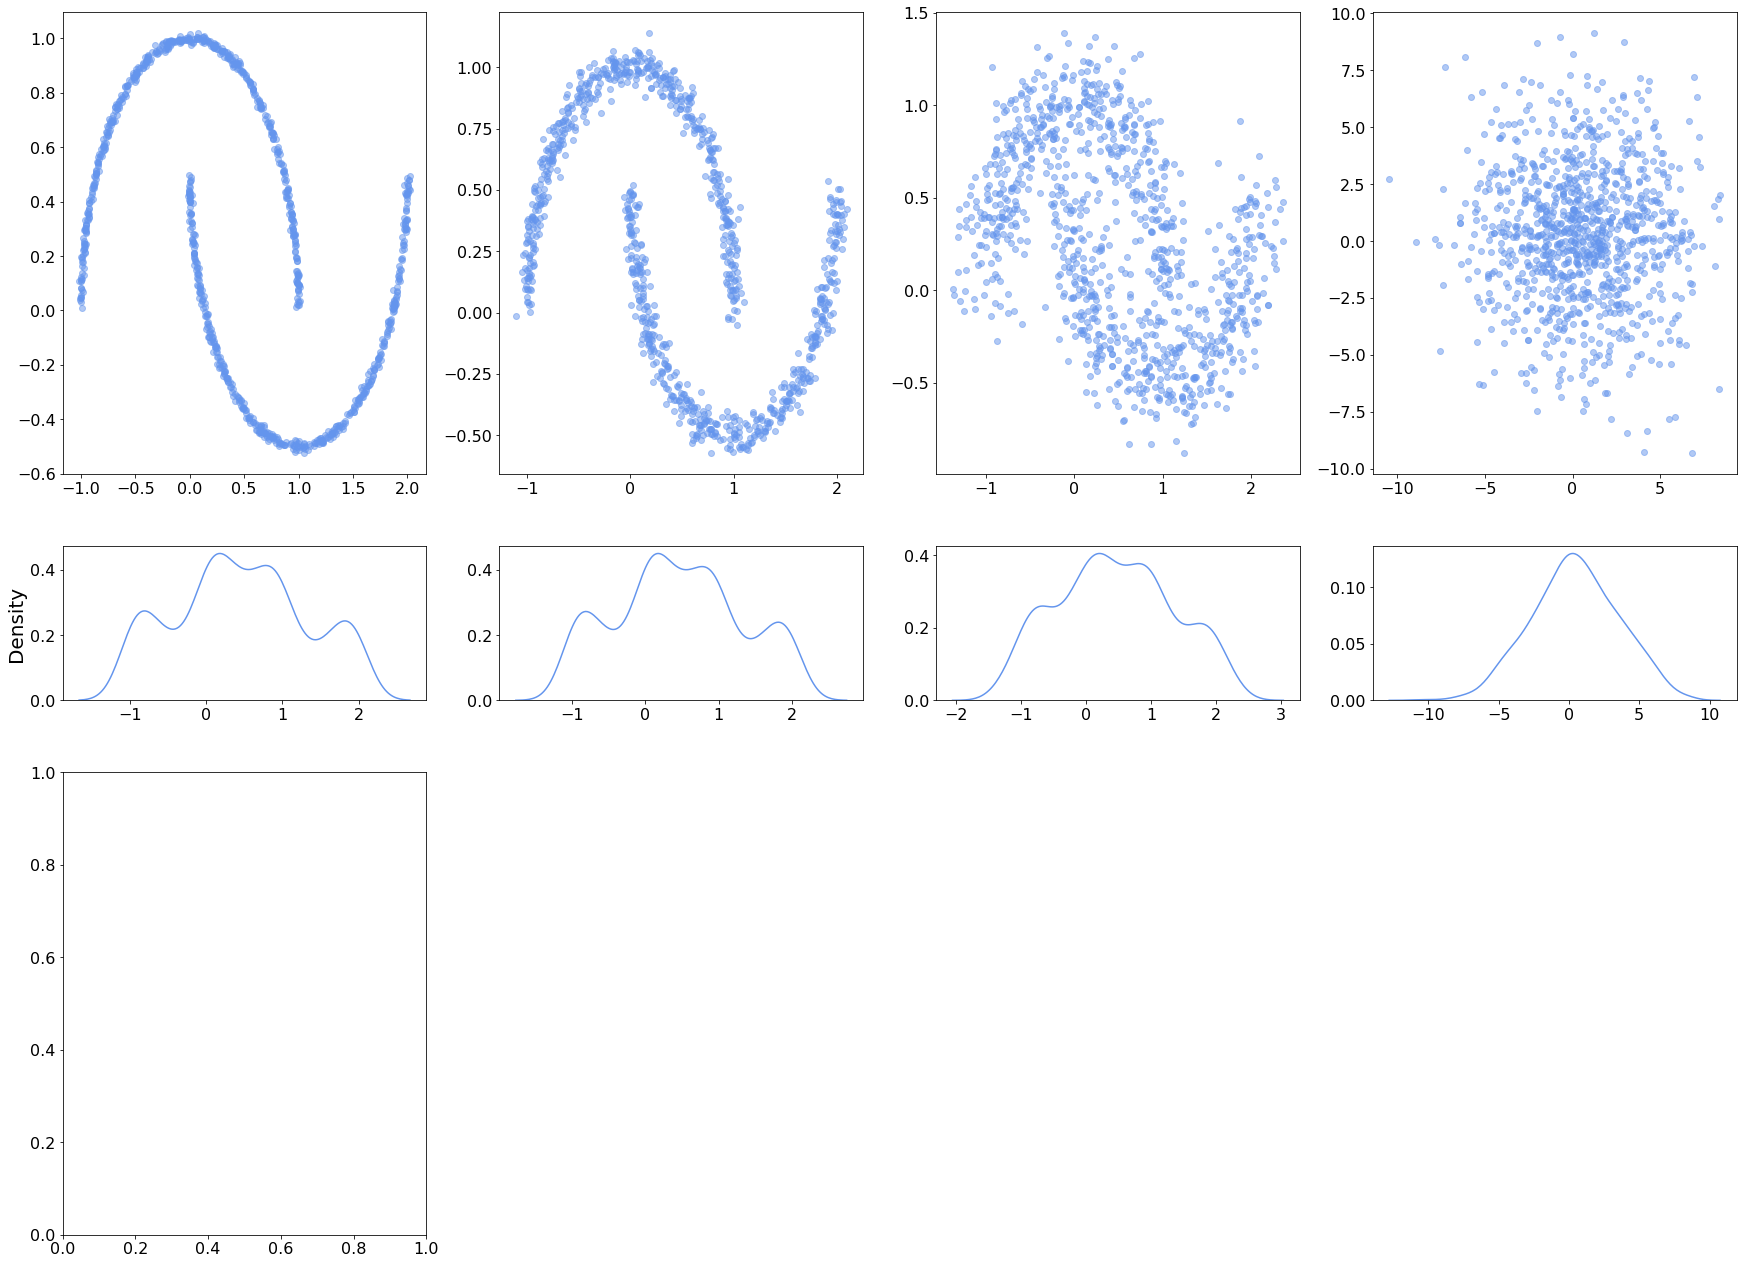

In [75]:

alpha = 0.5
col = 'cornflowerblue'

gs = gridspec.GridSpec(3, 4, height_ratios=[3, 1, 3]) 
fig = plt.figure(figsize=(30,22.5))

plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.serif'] = ['Computer Modern']

ax0 = plt.subplot(gs[0])
ax0.scatter(sample[:,0], sample[:,1], alpha=alpha, color=col)

ax1 = plt.subplot(gs[1])
ax1.scatter(qtr[:,0], qtr[:,1], alpha=alpha, color=col)

ax2 = plt.subplot(gs[2])
ax2.scatter(half[:,0], half[:,1], alpha=alpha, color=col)

ax3 = plt.subplot(gs[3])
ax3.scatter(full[:,0], full[:,1], alpha=alpha, color=col)

ax4 = plt.subplot(gs[4])
sns.kdeplot(sample[:,0], color=col)
plt.ylabel('Density', fontsize = 20)

ax5 = plt.subplot(gs[5])
sns.kdeplot(qtr[:,0], color=col)
plt.ylabel('')

ax6 = plt.subplot(gs[6])
sns.kdeplot(half[:,0], color=col)
plt.ylabel('')

ax7 = plt.subplot(gs[7])
sns.kdeplot(full[:,0], color=col)
plt.ylabel('')

ax8 = plt.subplot(gs[8])
plt.scatter(xs[-1][:,0], xs[-1][:,1], alpha=alpha, color=col)

ax9 = plt.subplot(gs[9])
plt.scatter(xs[-100][:,0], xs[-100][:,1], alpha=alpha, color=col)

ax10 = plt.subplot(gs[10])
plt.scatter(xs[-500][:,0], xs[-500][:,1], alpha=alpha, color=col)

ax11 = plt.subplot(gs[11])
plt.scatter(xs[0][:,0], xs[0][:,1], alpha=alpha, color=col)


#fig.savefig('plots/diffusion_basic_ex.png', bbox_inches='tight', pad_inches=0.1)

# SDE diffusion plots

## VE diffusion

In [23]:
def get_diffused(data, n, sde):
    data = data.copy()
    t = 1e-5
    dt = 1/n
    diffused = [data.copy()]
    for i in range(n):
        drift, diffusion = sde(data, t)
        
        data += drift * dt
        data += diffusion * np.random.randn(1)[0] * np.sqrt(dt)
        
        t += dt
        
        diffused.append(data.copy())
    
    return diffused

In [6]:
sigma_min=0.01
sigma_max=3
def sde_VE(x, t):
    sigma = sigma_min * (sigma_max / sigma_min) ** t
    diffusion = sigma * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))
    drift = 0
    return drift, diffusion

In [33]:
def sde_VE(x, t, sigma_min, sigma_max):
    sigma = sigma_min * (sigma_max / sigma_min) ** t
    diffusion = sigma * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))
    drift = 0
    return drift, diffusion

def get_diffused_2D(obs, n, sde, sigma_min, sigma_max):
    data = obs.clone().detach()
    t = 1e-5
    dt = 1/n
    diffused = [data.clone().detach()]
    for i in range(n):
        drift, diffusion = sde(data, t, sigma_min, sigma_max)
        data += drift * dt
        data += diffusion * torch.randn(2) * np.sqrt(dt)
        diffused.append(data.clone().detach())
        t += dt

    return torch.vstack(diffused)

In [61]:
diff = [get_diffused_2D(torch.tensor(sample[i]), 1000, sde_VE, 0.01, 3) for i in range(1000)]

In [62]:
og = torch.vstack([diff[i][0] for i in range(1000)])

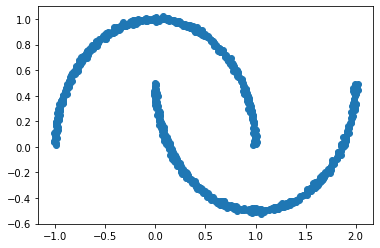

In [63]:
plt.scatter(og[:,0], og[:,1])

In [66]:
qtr = torch.vstack([diff[i][250] for i in range(1000)])

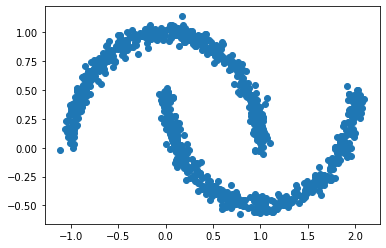

In [67]:
plt.scatter(qtr[:,0], qtr[:,1])

In [68]:
half = torch.vstack([diff[i][500] for i in range(1000)])

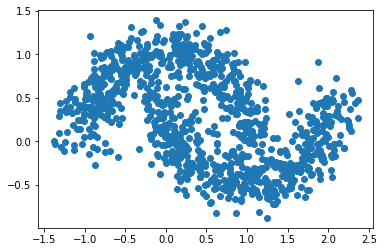

In [69]:
plt.scatter(half[:,0], half[:,1])

In [70]:
three_qtr = torch.vstack([diff[i][750] for i in range(1000)])

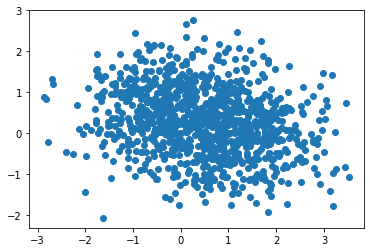

In [71]:
plt.scatter(three_qtr[:,0], three_qtr[:,1])

In [72]:
full = torch.vstack([diff[i][1000] for i in range(1000)])

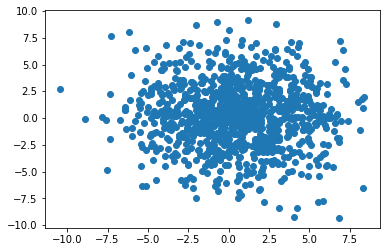

In [73]:
plt.scatter(full[:,0], full[:,1])

In [258]:
idx = np.random.choice(range(5000), 10000)
sample = moons[idx, 0]

In [259]:
walks = []
for i in sample:
    walk = get_diffused(i, 1000, sde_VE)
    walks.append(walk)

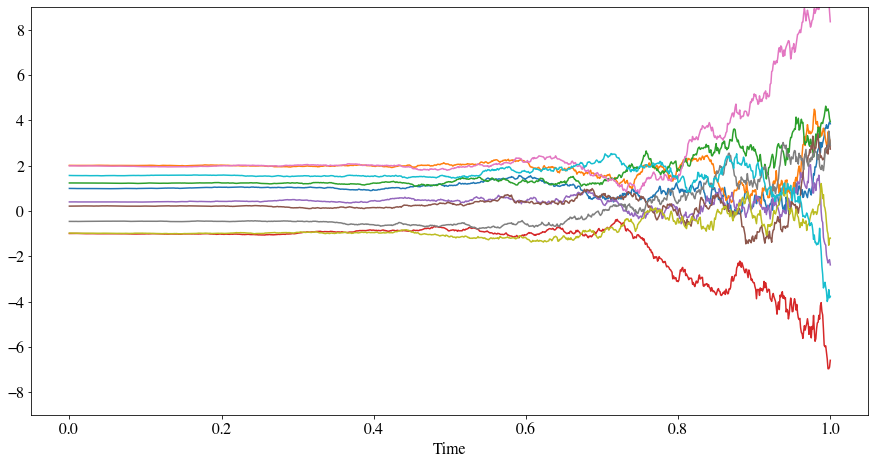

In [246]:
plt.rcParams.update({'font.size': 16})
font = 'Times'
hfont = {'fontname':font}
fig = plt.figure(figsize=(15,7.5))


    
for i in range(len(sample)):
    plt.plot(np.linspace(1e-5,1, 1001), walks[i])
    ax = plt.gca()
    ax.set_ylim([-9, 9])
    plt.xlabel('Time', **hfont)
    plt.yticks(fontname = font)
    plt.xticks(fontname = font)
    
#fig.savefig('plots/VE_SDE.png', bbox_inches='tight', pad_inches=0.1)

In [260]:
last = [w[-1] for w in walks]

In [262]:
np.mean(moons)

0.3751227022167259

Mean should be the same as the original datapoint (or 0??)

In [265]:
np.mean(last)

0.5214299077401613

Variance should be sigma_max^2, which is 3^2 = 9

In [266]:
np.var(last)

9.629794983654874

## VP diffusion

In [160]:
beta_min = 0.1
beta_max = 20
def sde_VP(x, t):
    beta_t = beta_min + t * (beta_max - beta_min)
    drift = -0.5 * beta_t * x
    diffusion = np.sqrt(beta_t)
    return drift, diffusion

In [239]:
walks = []

for i in sample:
    walk = get_diffused(i, 1000, sde_VP)
    walks.append(walk)

normal_dist = np.random.randn(100000)

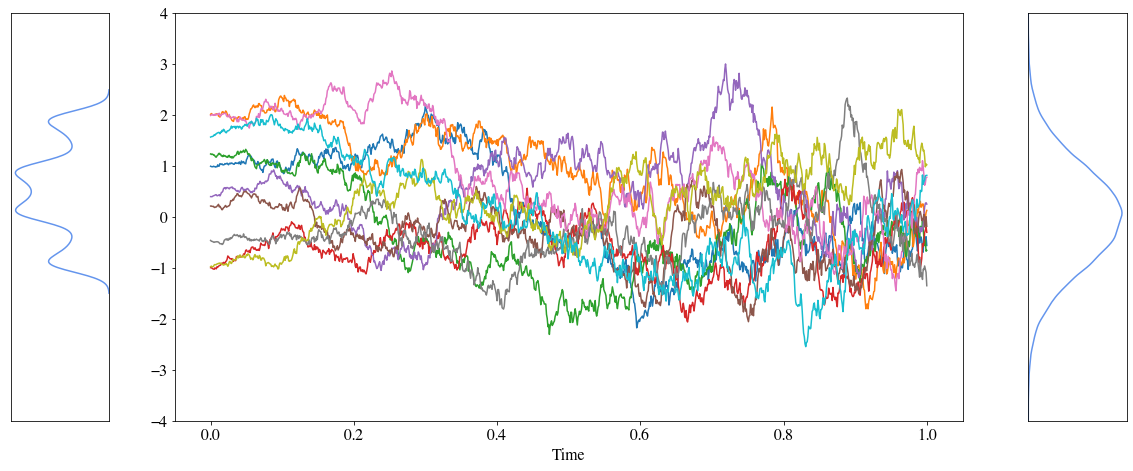

In [241]:
col = 'cornflowerblue'
plt.rcParams.update({'font.size': 16})
font = 'Times'
hfont = {'fontname':font}

gs = gridspec.GridSpec(1, 3, width_ratios=[1, 8, 1]) 
fig = plt.figure(figsize=(20,7.5))

ax0 = plt.subplot(gs[0])
ax0 = sns.kdeplot(y=moons[:,0], color=col)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_ylim([-4, 4])
plt.xlabel('', **hfont)
ax0.invert_xaxis()


ax1 = plt.subplot(gs[1])
for i in range(len(sample)):
    ax1.plot(np.linspace(1e-5,1, 1001), walks[i])
    ax1.set_ylim([-4, 4])
    plt.xlabel('Time', **hfont)
    plt.yticks(fontname = font)
    plt.xticks(fontname = font)
    
ax2 = plt.subplot(gs[2])
ax2 = sns.kdeplot(y=normal_dist, color=col)
ax2.set_ylim([-4, 4])
ax2.set_xticks([])
ax2.set_yticks([])
plt.xlabel('', **hfont)

#fig.savefig('plots/VP_SDE.png', bbox_inches='tight', pad_inches=0.1)

In [232]:
last = [w[-1] for w in walks]

In [88]:
moons[[0], 0]

array([1.6790611])

Mean should be 0

In [89]:
np.mean(last)

0.0635854522577793

Variance should be 1

In [90]:
np.var(last)

0.142647671983721

# 2D Experiment Results

## Unconditional plots

# BOD Experiment Results